In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file_sample_names = ['input', 'assembled']
counts = []

for sample in file_sample_names:
    for replicate in range(1, 3):
        with open(f'../../data/20240527_pipeline_run/counts/{sample}_rep_{replicate}.txt', 'rt') as f:
            clusters = (x.split("\t") for x in f.read().splitlines())
            for center, count in clusters:
                counts.append((sample, replicate, center, int(count)))

df = pd.DataFrame(counts, columns=['sample', 'rep', 'sequence', 'count'])
df['sample_unique'] = df['sample'] + '_' + df['rep'].astype(str)
df.head()

,sample,rep,sequence,count,sample_unique
0,input,1,GCAGGTGTCGGCGGGGTGAGGGGGGTGGGG,407,input_1
1,input,1,AGAGGGGGAGGGAGGGAGGGGCGGGCTGCA,328,input_1
2,input,1,CGAGGCGAGGGCGAATTAGGAACAGAGAAG,325,input_1
3,input,1,GTTTGGGGAGGGGGGAGAGGGGGGGACGGC,321,input_1
4,input,1,GTTAGCGGCGGGGGGGTGGGGCGGCGGGCG,315,input_1


<AxesSubplot: xlabel='count', ylabel='Count'>

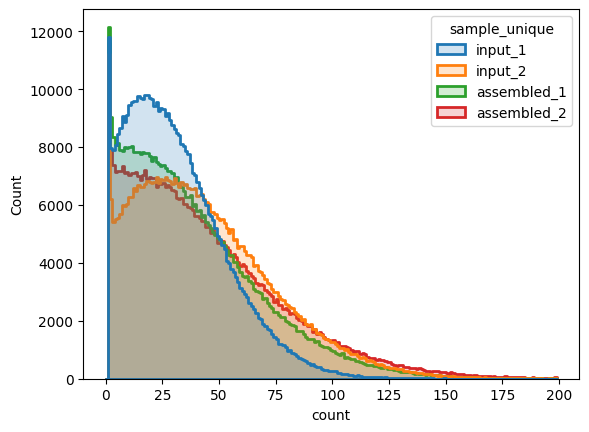

In [3]:
sns.histplot(df, x='count', hue='sample_unique', element='step', bins=range(200), alpha=0.2, linewidth=2)

In [4]:
for sample in file_sample_names:
    for replicate in range(1, 3):
        sample_df = df[(df['sample'] == sample) & (df['rep'] == replicate)]
        print(f'{sample} {replicate}: {sample_df["count"].sum()/len(sample_df)}')

input 1: 31.02630189056717
input 2: 43.53198524963154
assembled 1: 38.58511294255143
assembled 2: 43.50732367808714


In [5]:
# normalize to counts per million for each sample_unique
df['cpm'] = df.groupby('sample_unique')['count'].transform(lambda x: x / x.sum() * 1e6)
df.head()

,sample,rep,sequence,count,sample_unique,cpm
0,input,1,GCAGGTGTCGGCGGGGTGAGGGGGGTGGGG,407,input_1,26.243678
1,input,1,AGAGGGGGAGGGAGGGAGGGGCGGGCTGCA,328,input_1,21.149696
2,input,1,CGAGGCGAGGGCGAATTAGGAACAGAGAAG,325,input_1,20.956254
3,input,1,GTTTGGGGAGGGGGGAGAGGGGGGGACGGC,321,input_1,20.698331
4,input,1,GTTAGCGGCGGGGGGGTGGGGCGGCGGGCG,315,input_1,20.311446


In [6]:
# split into input and assembled, then merge on sequence
df.drop(columns='sample_unique', inplace=True)
df_input = df[df['sample'] == 'input']
df_assembled = df[df['sample'] == 'assembled']
df_merged = pd.merge(df_input, df_assembled, on=['sequence', 'rep'], suffixes=('_input', '_assembled'))
df_merged.head()

,sample_input,rep,sequence,count_input,cpm_input,sample_assembled,count_assembled,cpm_assembled
0,input,1,GCAGGTGTCGGCGGGGTGAGGGGGGTGGGG,407,26.243678,assembled,38,1.984476
1,input,1,AGAGGGGGAGGGAGGGAGGGGCGGGCTGCA,328,21.149696,assembled,105,5.483420
2,input,1,CGAGGCGAGGGCGAATTAGGAACAGAGAAG,325,20.956254,assembled,127,6.632327
3,input,1,GTTTGGGGAGGGGGGAGAGGGGGGGACGGC,321,20.698331,assembled,285,14.883568
4,input,1,GTTAGCGGCGGGGGGGTGGGGCGGCGGGCG,315,20.311446,assembled,15,0.783346


In [7]:
# filter for count > 10
df_merged_filtered = df_merged[df_merged['count_input'] > 20]

In [8]:
df_merged_filtered['log2_fc'] = np.log2(df_merged_filtered['cpm_assembled'] / df_merged_filtered['cpm_input'])

C:\Users\nmateyko\AppData\Local\Temp\ipykernel_32068\1267110533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_filtered['log2_fc'] = np.log2(df_merged_filtered['cpm_assembled'] / df_merged_filtered['cpm_input'])


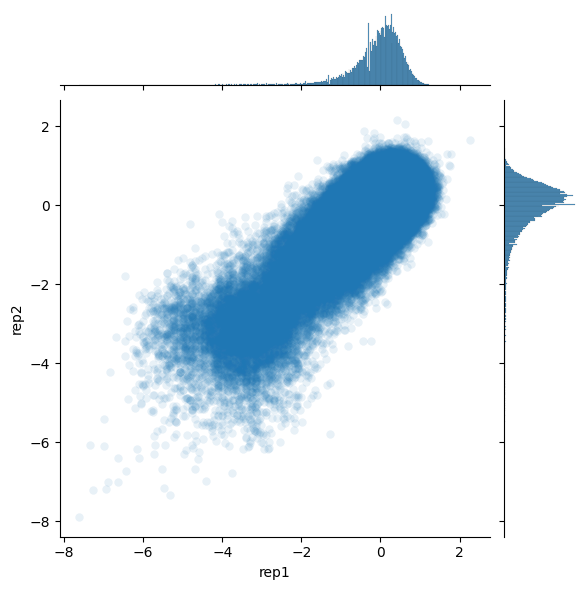

In [9]:
# merge replicates and plot correlation of log2 ratios
df_pivot = df_merged_filtered.pivot(index='sequence', columns='rep', values='log2_fc')
df_pivot.columns = ['rep1', 'rep2']
df_pivot = df_pivot.dropna()
sns.jointplot(data=df_pivot, x='rep1', y='rep2', alpha=0.1, linewidth=0)

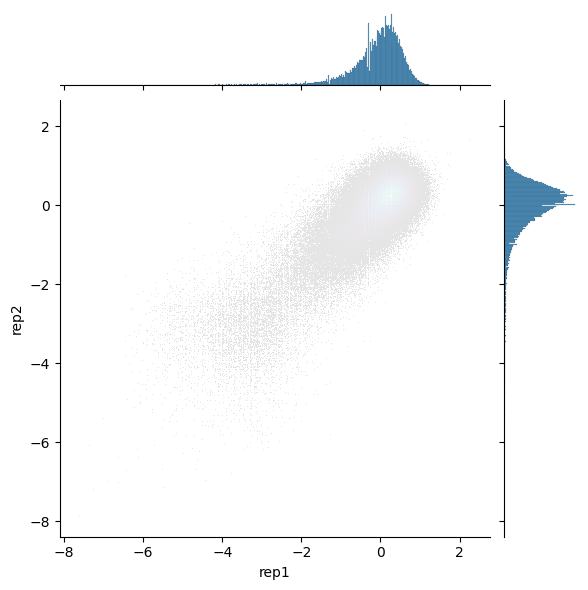

In [10]:
# merge replicates and plot correlation of log2 ratios
df_pivot = df_merged_filtered.pivot(index='sequence', columns='rep', values='log2_fc')
df_pivot.columns = ['rep1', 'rep2']
df_pivot = df_pivot.dropna()
sns.jointplot(data=df_pivot, x='rep1', y='rep2', alpha=0.1, linewidth=0, kind='hist', cmap='mako')

In [11]:
#calculate pearson correlation
correlation = df_pivot.corr().values[0, 1]
correlation

0.7845923622117655

Determine what percentage of sequences are bad at Gibson assembly (log2(fc) < -2 in both replicates)

In [12]:
# determine the number of sequences with a log2 fold change less than -2 in both replicates
num_bad = df_merged_filtered[(df_merged_filtered['log2_fc'] < -1) & (df_merged_filtered['rep'] == 1)].merge(
    df_merged_filtered[(df_merged_filtered['log2_fc'] < -1) & (df_merged_filtered['rep'] == 2)], on='sequence'
).shape[0]

print(num_bad/df_merged_filtered.shape[0])

0.028522522760374727


In [13]:
# sns.jointplot(data=df_pivot, x='rep1', y='rep2', kind='kde', cmap='crest', n_levels=60, fill=True)

<AxesSubplot: xlabel='GC', ylabel='Count'>

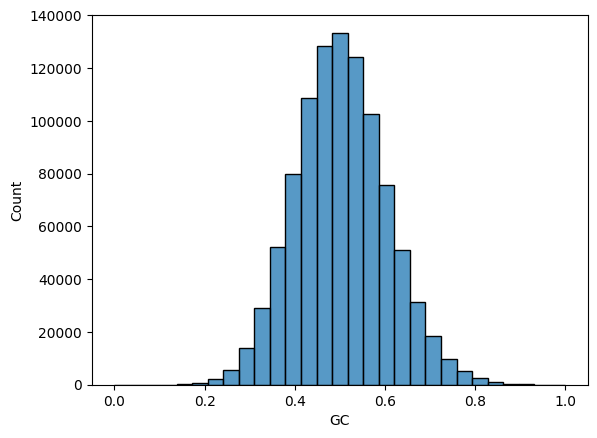

In [14]:
df_merged['GC'] = df_merged['sequence'].apply(lambda x: (x.count('G') + x.count('C')) / len(x))
sns.histplot(df_merged, x='GC', bins=np.linspace(0, 1, 30))

<AxesSubplot: >

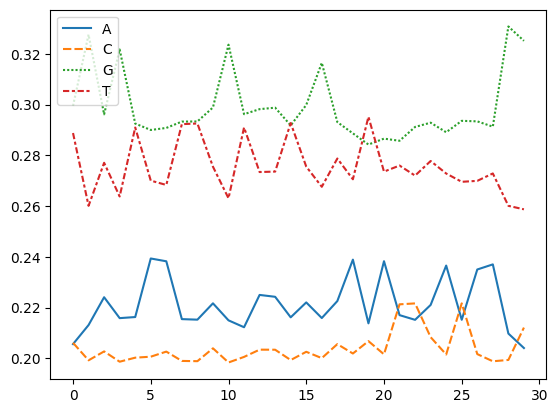

In [15]:
counts = {'A': [0] * 30, 'C': [0] * 30, 'G': [0] * 30, 'T': [0] * 30}
for seq in df_merged['sequence']:
    for i, base in enumerate(seq):
        counts[base][i] += 1

percent_counts = {'A': [], 'C': [], 'G': [], 'T': []}

# convert counts to percentages across all bases
for A_count, C_count, G_count, T_count in zip(counts['A'], counts['C'], counts['G'], counts['T']):
    total = A_count + C_count + G_count + T_count
    percent_counts['A'].append(A_count / total)
    percent_counts['C'].append(C_count / total)
    percent_counts['G'].append(G_count / total)
    percent_counts['T'].append(T_count / total)

df_base_percent_counts = pd.DataFrame(percent_counts)
sns.lineplot(data=df_base_percent_counts)

C:\Users\nmateyko\AppData\Local\Temp\ipykernel_32068\600673297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_filtered['GC'] = df_merged_filtered['sequence'].apply(lambda x: round((x.count('G') + x.count('C')) / len(x), 2))


<AxesSubplot: xlabel='GC', ylabel='log2_fc'>

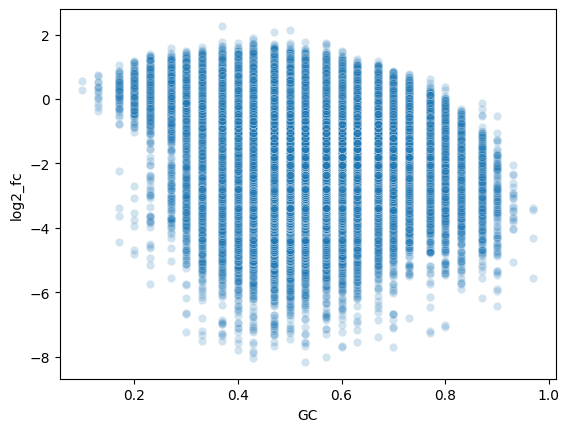

In [16]:
df_merged_filtered['GC'] = df_merged_filtered['sequence'].apply(lambda x: round((x.count('G') + x.count('C')) / len(x), 2))
sns.scatterplot(data=df_merged_filtered, x='GC', y='log2_fc', alpha=0.2)

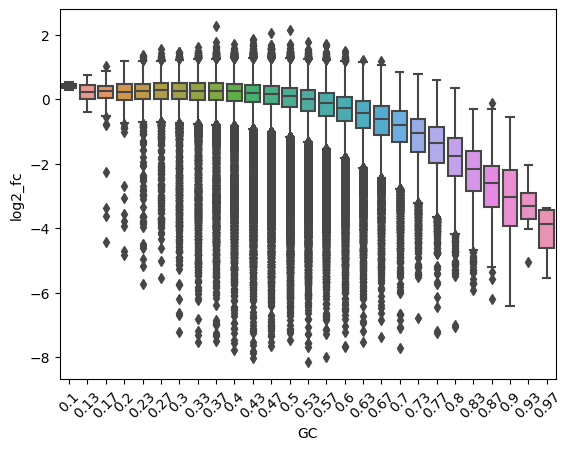

In [17]:
sns.boxplot(data=df_merged_filtered, x='GC', y='log2_fc')
# rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

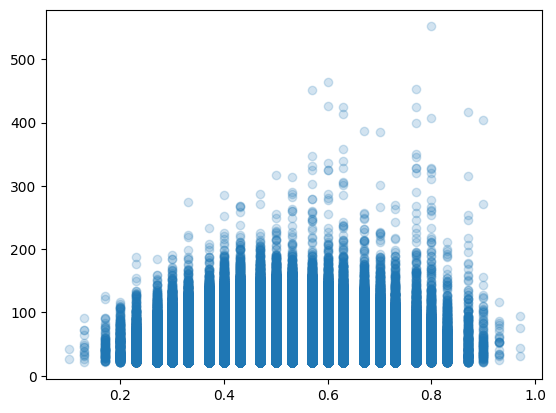

In [18]:
plt.scatter(df_merged_filtered['GC'], df_merged_filtered['count_input'], alpha=0.2)

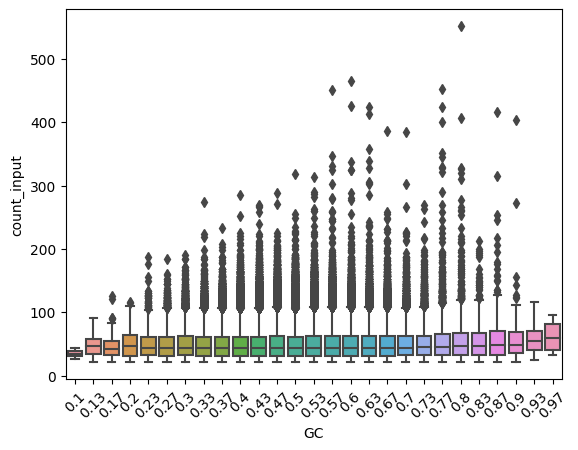

In [19]:
sns.boxplot(data=df_merged_filtered, x='GC', y='count_input')
# rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

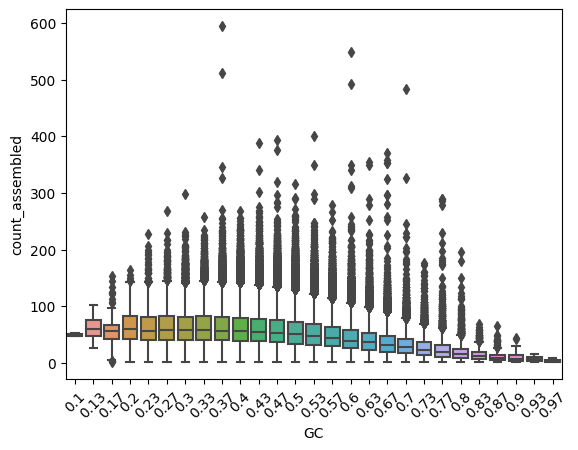

In [20]:
sns.boxplot(data=df_merged_filtered, x='GC', y='count_assembled')
# rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

In [21]:
# calculate log2(fc) median and mean for each replicate
df_summary = df_merged_filtered.groupby('rep').agg({'log2_fc': ['mean', 'median']})
df_summary

log2_fc          
         mean    median
rep                    
1   -0.156977  0.022046
2   -0.135682  0.035320

In [22]:
# remove all rows where the sequences contains GCTCTTC or GAAGAGC
df_merged_filtered_noSapI = df_merged_filtered[~df_merged_filtered['sequence'].str.contains('GCTCTTC|GAAGAGC')]


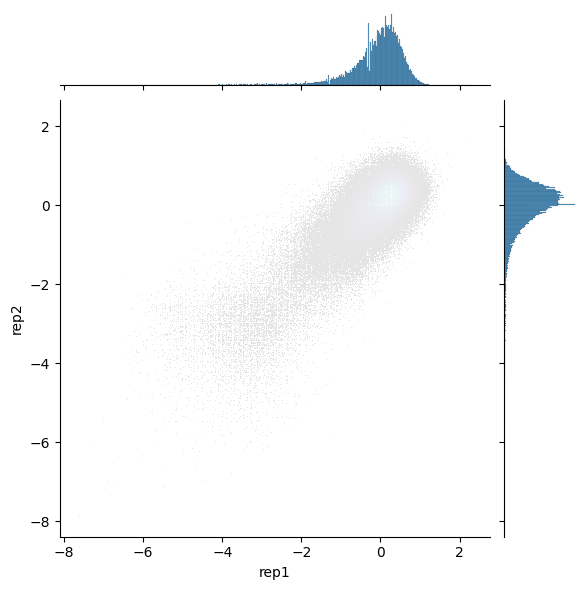

In [23]:
# merge replicates and plot correlation of log2 ratios
df_pivot = df_merged_filtered_noSapI.pivot(index='sequence', columns='rep', values='log2_fc')
df_pivot.columns = ['rep1', 'rep2']
df_pivot = df_pivot.dropna()
sns.jointplot(data=df_pivot, x='rep1', y='rep2', alpha=0.1, linewidth=0, kind='hist', cmap='mako')

In [25]:
# determine the number of sequences with a log2 fold change less than -2 in both replicates
num_bad = df_merged_filtered_noSapI[(df_merged_filtered_noSapI['log2_fc'] < -1) & (df_merged_filtered_noSapI['rep'] == 1)].merge(
    df_merged_filtered_noSapI[(df_merged_filtered_noSapI['log2_fc'] < -1) & (df_merged_filtered_noSapI['rep'] == 2)], on='sequence'
).shape[0]

print(num_bad/df_merged_filtered.shape[0])
print(num_bad/df_merged_filtered_noSapI.shape[0])

0.0281983698482055
0.028252074635441694
